In [90]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import sys
from UclaDataLoader import UclaDataLoader
from CedarsDataLoader import CedarsDataLoader
from CombineData import CombineData
from SplitData import SplitData
from TrainModel import TrainModel
from TestModel import TestModel
import viz_utils
import numpy as np

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# ucla files
ddr_path= <path_to_ddr_files>
ucla_labs = os.path.join(ddr_path,'covid_labs.rpt')
ucla_encounters = os.path.join(ddr_path,'covid_encounters.rpt')
ucla_patients = os.path.join(ddr_path,'covid_patients.rpt')

# cedars files
cedars_patients = <path_to_cedars_patients_file>
cedars_flat_file = <path_to_cedars_flat_file>

# Read data #
dataSets = ['ucla', 'cedars']
dataDict = {}

anyInfMarker = True

excludeSupps = False

In [92]:
%%time
dataDict['ucla'] = {}
dataDict['ucla']['data'], dataDict['ucla']['trainIDs'], dataDict['ucla']['testIDs'] =\
    UclaDataLoader(ucla_labs, ucla_encounters, ucla_patients, anyInfMarker=anyInfMarker)

100%|██████████| 4941/4941 [00:02<00:00, 2380.84it/s]


Number of features: 21


100%|██████████| 3242/3242 [00:29<00:00, 108.56it/s]


CPU times: user 1min 12s, sys: 6.49 s, total: 1min 19s
Wall time: 1min 17s


In [93]:
immsuppfile = <path_to_ucla_immunosuppressed_file>
supps = pd.read_csv(immsuppfile, error_bad_lines=False)['PatientEncounterCSNID'].values
if excludeSupps:
    dataDict['ucla']['data']=dataDict['ucla']['data'].loc[\
                                    ~dataDict['ucla']['data']['PatientEncounterCSNID'].isin(supps)]
    dataDict['ucla']['trainIDs'] = [x for x in dataDict['ucla']['trainIDs'] if x not in supps]
    dataDict['ucla']['testIDs'] = [x for x in dataDict['ucla']['testIDs'] if x not in supps]

In [94]:
dataDict['cedars'] = {}
dataDict['cedars']['data'], dataDict['cedars']['trainIDs'], dataDict['cedars']['testIDs'] =\
    CedarsDataLoader(cedars_patients, cedars_flat_file, anyInfMarker=anyInfMarker)

In [95]:
print('Pool numbers:')
all_ucla = len(dataDict['ucla']['data'])
train_ucla = len(dataDict['ucla']['trainIDs'])
test_ucla = len(dataDict['ucla']['testIDs'])
all_cedars = len(dataDict['cedars']['data'])
train_cedars = len(dataDict['cedars']['trainIDs'])
test_cedars = len(dataDict['cedars']['testIDs'])
print('UCLA - all: %i, train: %i, test: %i' % (all_ucla,train_ucla,test_ucla))
print('Cedars - all: %i, train: %i, test: %i' % (all_cedars,train_cedars,test_cedars))

Pool numbers:
UCLA - all: 901, train: 901, test: 826
Cedars - all: 171, train: 171, test: 0


In [96]:
# Combine data #
allData, trainIDs, testIDs = CombineData(dataDict)

ucla samples: 901
cedars samples: 171


In [97]:
allData.groupby(by=['positive']).count()[['PatientEncounterCSNID']]

,PatientEncounterCSNID
positive,
0,786
1,286


In [98]:
# Dropping features, if necessary #
dropCols = ['D-DIMER']#, 'Ferritin', 'Lactate Dehydrogenase', 'C-Reactive Protein']
allData = allData.drop(dropCols, axis=1)

randSt=np.random.RandomState(10)

In [99]:
# Split data #
trainData, valData, testData = SplitData(allData, trainIDs, testIDs, n_val=30, n_test=60, balanced=False, random_state=7)

Experiment: full
Optimizing decision threshold...
Threshold: 0.15     Precision: 0.30     Recall: 1.00     Fbeta: 0.47
Threshold: 0.16     Precision: 0.25     Recall: 1.00     Fbeta: 0.42
Threshold: 0.17     Precision: 0.35     Recall: 1.00     Fbeta: 0.52
Threshold: 0.18     Precision: 0.56     Recall: 1.00     Fbeta: 0.72
Threshold: 0.19     Precision: 0.60     Recall: 1.00     Fbeta: 0.77
Threshold: 0.20     Precision: 0.71     Recall: 0.98     Fbeta: 0.86
Threshold: 0.21     Precision: 0.76     Recall: 0.94     Fbeta: 0.89
Threshold: 0.22     Precision: 0.76     Recall: 0.91     Fbeta: 0.87
Threshold: 0.23     Precision: 0.78     Recall: 0.89     Fbeta: 0.86
Threshold: 0.24     Precision: 0.77     Recall: 0.84     Fbeta: 0.83
Threshold: 0.25     Precision: 0.79     Recall: 0.82     Fbeta: 0.81
Threshold: 0.26     Precision: 0.79     Recall: 0.81     Fbeta: 0.80
Threshold: 0.27     Precision: 0.80     Recall: 0.80     Fbeta: 0.80
Threshold: 0.28     Precision: 0.79     Recall: 0.78 

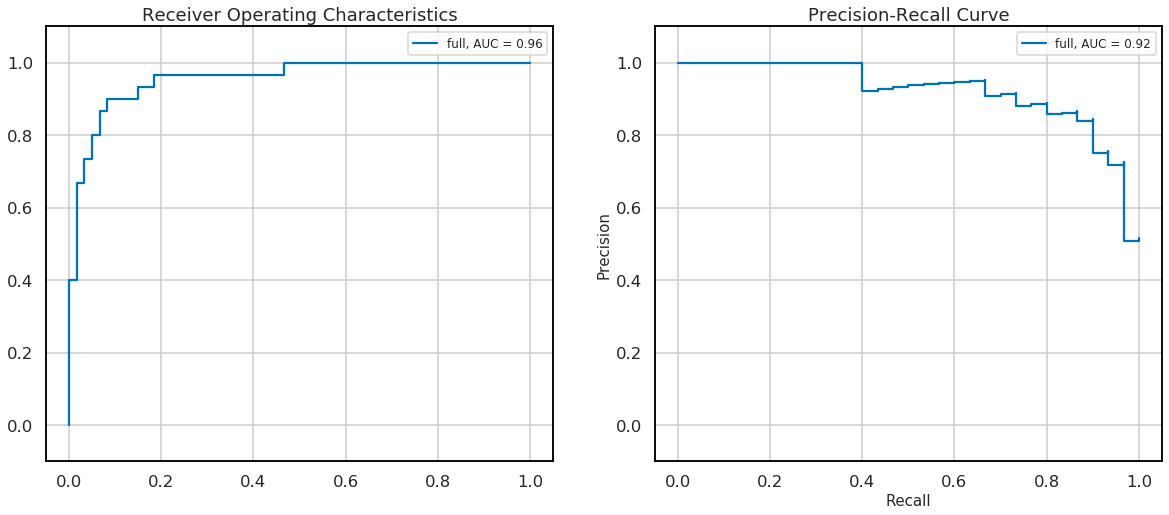

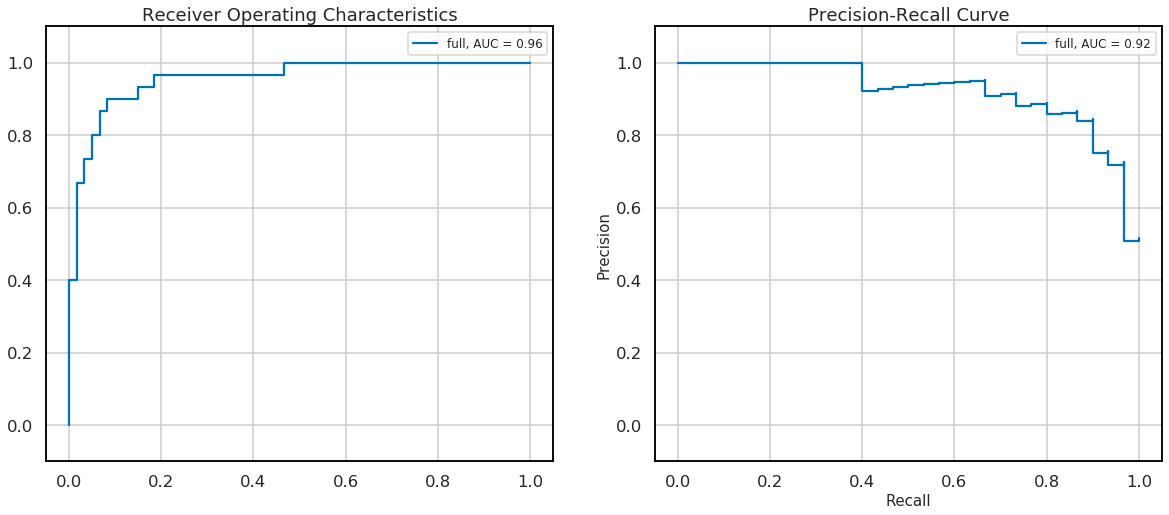

In [100]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')
experiments={}
expnames=['full']#, 'OnlyCBCandDem', 'NoFerritin', 'NoLDH', 'NoCRP']

y_vectors = {}

plotpath = <plot_path>

f1, axarr1 = plt.subplots(1, 2, figsize=(20, 8))
axarr1[0].set_title('Receiver Operating Characteristics', fontsize=18)
axarr1[0].set_ylim((-0.1,1.1))
axarr1[1].set_title('Precision-Recall Curve', fontsize=18)
axarr1[1].set_ylim((-0.1,1.1))
f2, axarr2 = plt.subplots(1, 2, figsize=(20, 8))
axarr2[0].set_title('Receiver Operating Characteristics', fontsize=18)
axarr2[0].set_ylim((-0.1,1.1))
axarr2[1].set_title('Precision-Recall Curve', fontsize=18)
axarr2[1].set_ylim((-0.1,1.1))

for exp in expnames:
    y_vectors[exp]={}
    print('Experiment: %s' % exp)
    colToDrop = []
    if exp == 'OnlyCBCandDem':
        colToDrop = ['Ferritin', 'Lactate Dehydrogenase', 'C-Reactive Protein']
    if exp == 'NoFerritin':
        colToDrop = ['Ferritin']
    if exp == 'NoLDH':
        colToDrop = ['Lactate Dehydrogenase']
    if exp == 'NoCRP':
        colToDrop = ['C-Reactive Protein']
        
    # Train and tune model #
    model = TrainModel(trainData.drop(colToDrop, axis=1), valData.drop(colToDrop, axis=1),\
                       iterations=10, beta=2, minThr=15, maxThr=40)
    # Test model #
    results = TestModel(model, testData.drop(colToDrop, axis=1), showReport=False)
    
    print('AUC:')
    print(results['roc']['auc'])
    print('PR_AUC:')
    print(results['prcurve']['auc'])

    y_test=results['y_test']
    y_prob=results['y_prob']
    y_pred=results['y_pred']
    y_vectors[exp]['y_test']=y_test
    y_vectors[exp]['y_prob']=y_prob
    y_vectors[exp]['y_preb']=y_pred

    viz_utils.plot_cis(list(y_test.values), np.array(y_prob), threshold_to_use=model[2], plot=False)
    print('......................................................')

    fpr,tpr,thr,auc = results['roc']['fpr'], results['roc']['tpr'], results['roc']['thr'], results['roc']['auc']
    prec, rec, pr_auc = results['prcurve']['precisions'], results['prcurve']['recalls'], results['prcurve']['auc']

    axarr1[0].plot(fpr,tpr, label=exp+', AUC = %.2f' % auc,linestyle='-', alpha=1)
    axarr1[1].step(rec,prec, label=exp+', AUC = %.2f' % pr_auc,linestyle='-', alpha=1)

    if exp=='full':
        axarr2[0].plot(fpr,tpr, label=exp+', AUC = %.2f' % auc,linestyle='-', alpha=1.0)
        axarr2[1].step(rec,prec, label=exp+', AUC = %.2f' % pr_auc,linestyle='-', alpha=1.0)
    else:
        axarr2[0].plot(fpr,tpr, label=exp+', AUC = %.2f' % auc,linestyle=':', alpha=0.8)
        axarr2[1].step(rec,prec, label=exp+', AUC = %.2f' % pr_auc,linestyle=':', alpha=0.8)
            
axarr1[1].set_xlabel('Recall', fontsize=15)
axarr1[1].set_ylabel('Precision', fontsize=15)
#f1.savefig(os.path.join(plotpath,'roc_comb_exps_noLegend_2.png'))
axarr1[0].legend(fontsize=12)
axarr1[1].legend(fontsize=12)
#f1.savefig(os.path.join(plotpath,'roc_comb_exps_Legend_2.png'))

axarr2[1].set_xlabel('Recall', fontsize=15)
axarr2[1].set_ylabel('Precision', fontsize=15)
#f2.savefig(os.path.join(plotpath,'roc_comb_exps_noLegend_v2_2.png'))
axarr2[0].legend(fontsize=12)
axarr2[1].legend(fontsize=12)
#f2.savefig(os.path.join(plotpath,'roc_comb_exps_Legend_v2_2.png'))

In [101]:
results = TestModel(model, testData.drop(colToDrop, axis=1), showReport=False)

print('AUC:')
print(results['roc']['auc'])
print('PR_AUC:')
print(results['prcurve']['auc'])

viz_utils.plot_cis(list(y_test.values), np.array(y_prob), threshold_to_use=model[2], plot=False)
print('......................................................')

AUC:
0.9561111111111111
PR_AUC:
0.9222722696323455
sensitivity : 1.00 95%CI (1.00, 1.00)
specificity : 0.21 95%CI (0.12, 0.32)
ppv : 0.38 95%CI (0.28, 0.49)
npv : 1.00 95%CI (1.00, 1.00)
fpr : 0.79 95%CI (0.68, 0.88)
tpr : 1.00 95%CI (1.00, 1.00)
......................................................


saving nl fig
saving l fig


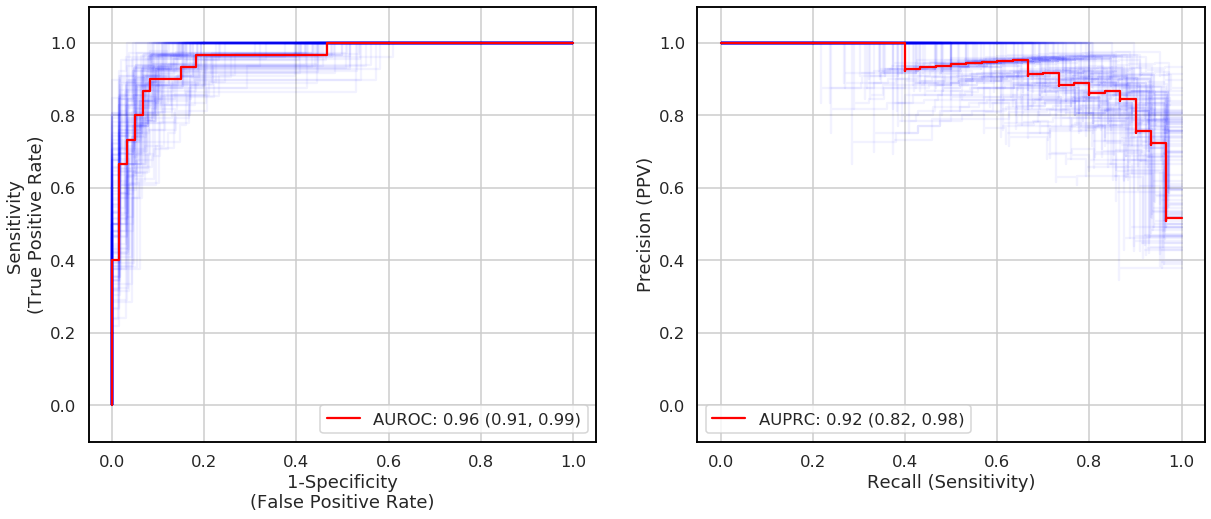

In [103]:
import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')
#y_test_save, y_prob_save = y_test, y_prob
nosupp_path = os.path.join(plotpath,'no_supp')
for exp in expnames:
    viz_utils.plot_results(y_vectors[exp]['y_test'], y_vectors[exp]['y_prob'],\
                           saveFigs=False, legend=True, figName=os.path.join(nosupp_path,'_'+exp+'_roc'))

In [104]:
print(model[2])

0.23


sensitivity : 1.00 95%CI (1.00, 1.00)
specificity : 0.21 95%CI (0.11, 0.32)
ppv : 0.39 95%CI (0.28, 0.49)
npv : 1.00 95%CI (1.00, 1.00)
fpr : 0.79 95%CI (0.68, 0.89)
tpr : 1.00 95%CI (1.00, 1.00)


(     FP  TP  FN  TN  sensitivity  specificity          ppv          npv  \
 0    47  30   0  13 1.0000000000 0.2166666667 0.3896103896 1.0000000000   
 1    50  27   0  13 1.0000000000 0.2063492063 0.3506493506 1.0000000000   
 2    47  31   0  12 1.0000000000 0.2033898305 0.3974358974 1.0000000000   
 3    46  27   0  17 1.0000000000 0.2698412698 0.3698630137 1.0000000000   
 4    42  33   0  15 1.0000000000 0.2631578947 0.4400000000 1.0000000000   
 ..   ..  ..  ..  ..          ...          ...          ...          ...   
 496  50  31   0   9 1.0000000000 0.1525423729 0.3827160494 1.0000000000   
 497  48  29   0  13 1.0000000000 0.2131147541 0.3766233766 1.0000000000   
 498  51  24   0  15 1.0000000000 0.2272727273 0.3200000000 1.0000000000   
 499  46  33   0  11 1.0000000000 0.1929824561 0.4177215190 1.0000000000   
 500  50  32   0   8 1.0000000000 0.1379310345 0.3902439024 1.0000000000   
 
              fpr          tpr  
 0   0.7833333333 1.0000000000  
 1   0.7936507937 1.

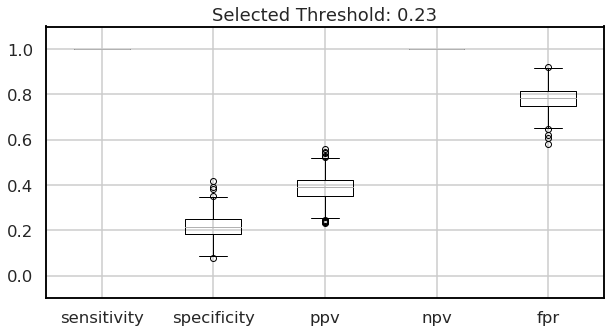

In [105]:
import numpy as np
y_test=results['y_test']
y_prob=results['y_prob']
y_pred=results['y_pred']

import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')

viz_utils.plot_cis(list(y_test.values), np.array(y_prob), threshold_to_use=model[2])


Precision: 0.95
Recall: 0.67
AUC: 0.82
F(1.0): 0.78
Index(['Hemoglobin', 'Absolute Lymphocyte Count', 'Absolute Neut Count',
       'PLATELET COUNT, AUTO', 'C-Reactive Protein', 'Ferritin',
       'Absolute Baso Count', 'Absolute Eos Count', 'Absolute Mono Count',
       'Lactate Dehydrogenase', 'Red Blood Cell Count', 'Lymp/Neut', 'Age',
       'Male'],
      dtype='object')
Index(['C-Reactive Protein', 'Ferritin', 'Lactate Dehydrogenase', 'Lymp/Neut',
       'Red Blood Cell Count', 'Absolute Mono Count', 'Absolute Eos Count',
       'Absolute Baso Count', 'PLATELET COUNT, AUTO', 'Absolute Neut Count',
       'Absolute Lymphocyte Count', 'Hemoglobin', 'Male', 'Age'],
      dtype='object')


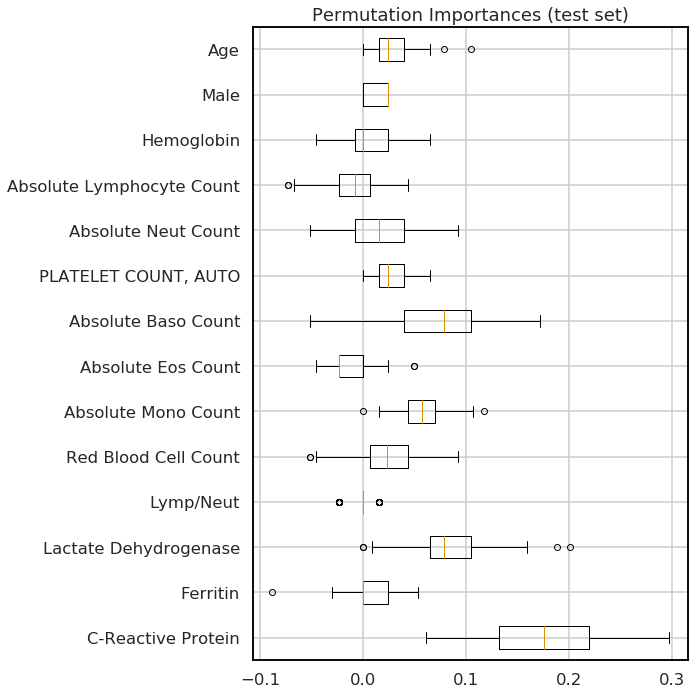

CPU times: user 15.3 s, sys: 730 ms, total: 16 s
Wall time: 1min 22s


In [106]:
%%time
viz_utils.plot_feature_importance(model,testData, n_repeats=100)

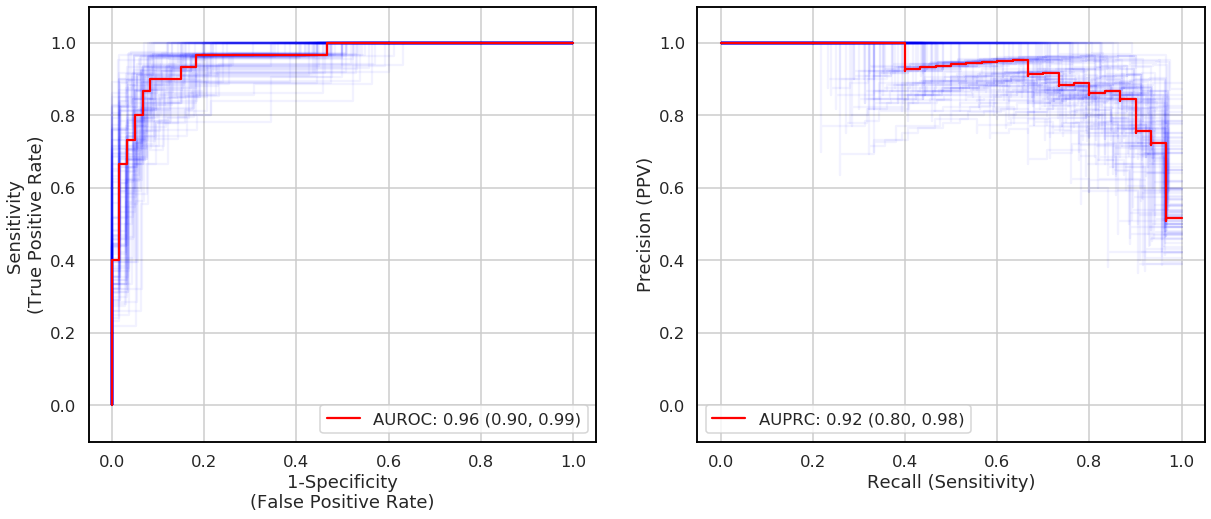

In [107]:
import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')
#y_test_save, y_prob_save = y_test, y_prob
viz_utils.plot_results(y_test, y_prob, saveFigs=False, legend=True)